### Fine-tune the pre-trained FaceNet model towards the QRI Face Dataset (85 images, 85 peaple) using binary loss function

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

import cv2

C:\Users\xiang.zhai\AppData\Local\Continuum\miniconda3\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from utils.FaceNet_utils import one_hot, distance_based_prediction, evaluate_model, face_dist, load_QRIFaceData, load_base_model

In [3]:
FNModel = load_base_model()

In [4]:
FNModel.count_params()

3743280

In [5]:
FaceData, labels, labels_OH, name_list = load_QRIFaceData()
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)
print(name_list)

(170, 3, 96, 96)
(170,)
(170, 85)
['Aaron_Close', 'Abdoulaye_Wedraogo', 'Adel_Heiba', 'Afshan_Jafferi', 'Agustin_Maqui', 'Aldo_Sanchez', 'Alexander_Aronovitz', 'Alisher_Yunuskhojayev', 'Ali_Garkasi', 'Ali_Karima', 'Amir_Kianinejad', 'Amir_Rahmani', 'Amir_Salehi', 'Anastasiya_Protasov', 'Ana_Negreira', 'Andrew_Dingee', 'Bart_Piela', 'Bijay_Banthia', 'Bill_Daugherty', 'Brian_Ames', 'Cedric_Fraces', 'Chad_Liu', 'Christophe_Nogaret', 'David_Castineira', 'David_Hoyt', 'David_Tyree', 'Denis_Prokofiev', 'Dilay_Watson', 'Don_Gehring', 'Ehsan_Davani', 'Ernesto_Cisnernos', 'Fayadhoi_Ibrahima', 'Franklin_Useche', 'Hamad_Darabi', 'Henry_Kernan', 'Hooman_Laali', 'Humberto_Godinez', 'Izzet_Arslan', 'Jacqueline_Bosworth', 'Jaime_Avendano', 'James_Howard', 'Jeff_Hutchison', 'Jenna_Salamah', 'Jeremy_Ma', 'Jeremy_Xia', 'Jesse_Shumway', 'Johanna_Smith', 'John_Marshall', 'John_Watkins', 'Juan_Troncoso', 'Kara_Bennett', 'Karen_Chen', 'Kate_Lewis', 'Kun_Liu', 'Lewis_Pham', 'Luis_Piasco', 'Maria_Mata', 'Mehe

In [6]:
nPeople = len(name_list)
nFace = FaceData.shape[0]
print('Number of people: %d, Number of faces: %d' % (nPeople, nFace))

Number of people: 85, Number of faces: 170


In [7]:
%time FaceEmbedding = FNModel.predict(FaceData)

Wall time: 10.5 s


In [9]:
pca = decomposition.PCA(n_components = 2)

In [13]:
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)

Text(0.5,1,'feature space')

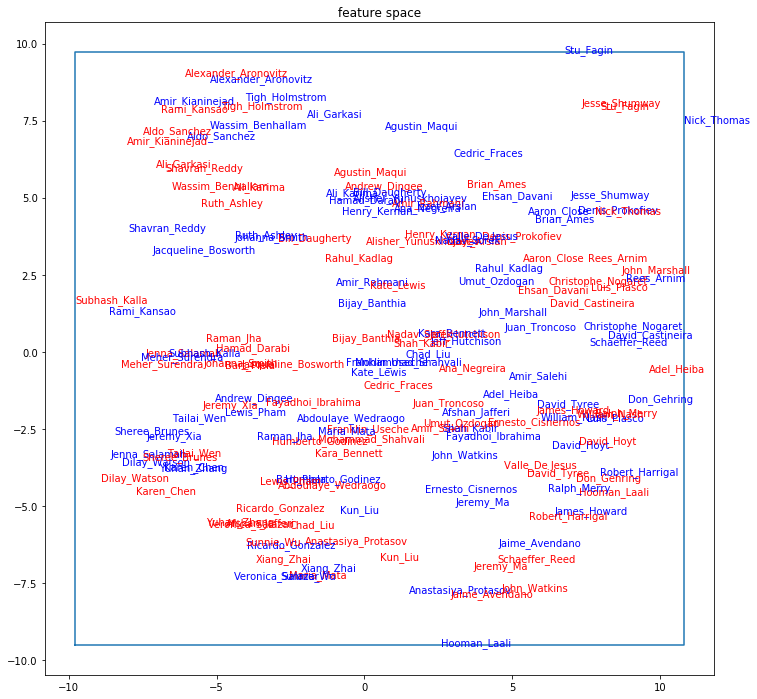

In [16]:
#plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.figure(figsize=(12,12))
xmin,xmax = x_feature_pca[:,0].min(),x_feature_pca[:,0].max()
ymin,ymax = x_feature_pca[:,1].min(),x_feature_pca[:,1].max()

plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin])
for i in range(nPeople):
    plt.text(x_feature_pca[2*i,0],x_feature_pca[2*i,1],name_list[labels[2*i]],color='b')
    plt.text(x_feature_pca[2*i+1,0],x_feature_pca[2*i+1,1],name_list[labels[2*i+1]],color='r')
plt.title('feature space')

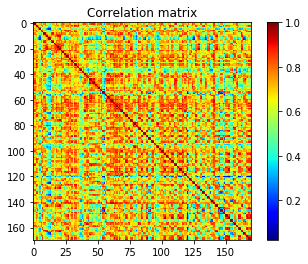

In [17]:
FaceEmbedding_Corr = np.corrcoef(FaceEmbedding)
plt.imshow(FaceEmbedding_Corr,cmap='jet')
plt.title('Correlation matrix')
plt.colorbar()

In [18]:
Distances_cross_dist = []
Distances_cross_dist_pair = []
FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]!=labels[j]:
            Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
            Distances_cross_dist_pair.append((i,j))
            
Distances_cross_dist = np.array(Distances_cross_dist)

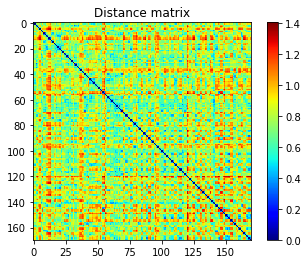

In [19]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.800 +\- 0.180


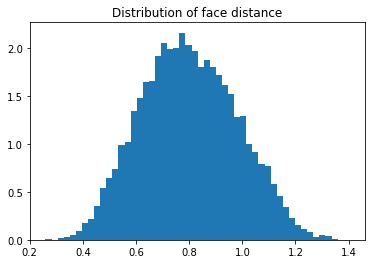

In [20]:
plt.figure()
_ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
plt.title('Distribution of face distance')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))

## Check similar faces

Karen_Chen Tailai_Wen 0.25911828918191343


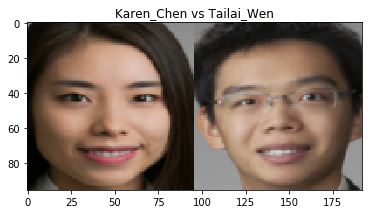

Jenna_Salamah Karen_Chen 0.26247301531001344


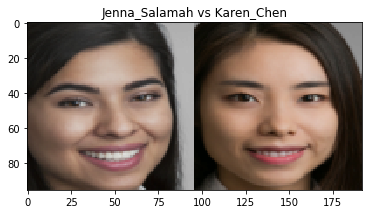

Karen_Chen Tailai_Wen 0.2918066318234507


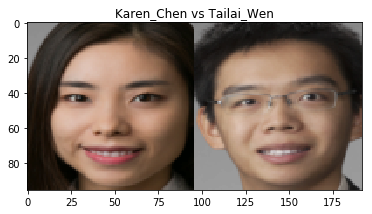

Hamad_Darabi Meher_Surendra 0.31256037322653196


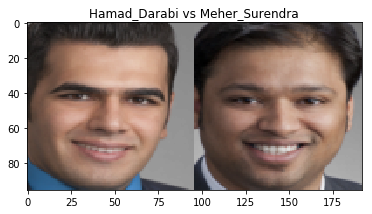

Dilay_Watson Sheree_Brunes 0.31369444784442324


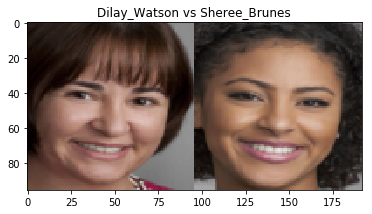

Jeremy_Xia Yuhan_Zhang 0.3154779946522731


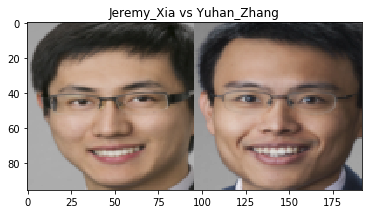

Lewis_Pham Tailai_Wen 0.3174682937764187


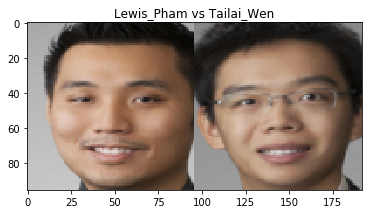

Abdoulaye_Wedraogo Bart_Piela 0.31752744652942494


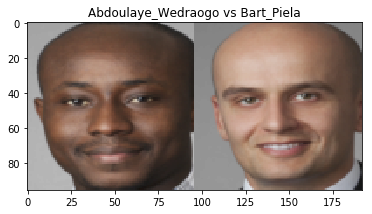

Franklin_Useche Mohammad_Shahvali 0.3183727032939993


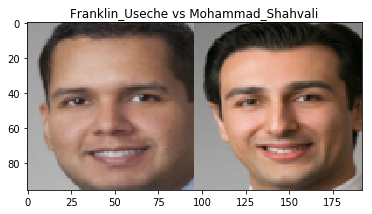

Shavran_Reddy Wassim_Benhallam 0.31899396535309005


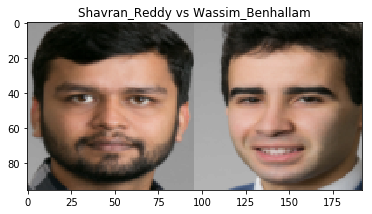

Karen_Chen Tailai_Wen 0.3283446468644492


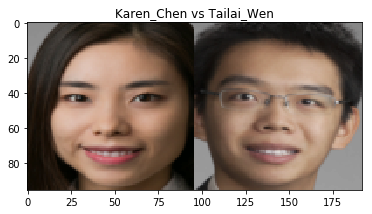

Franklin_Useche Hamad_Darabi 0.3301056448372734


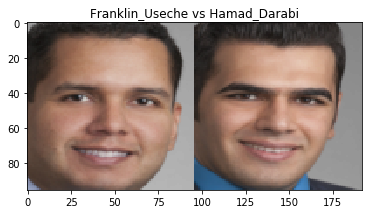

Cedric_Fraces Henry_Kernan 0.3329385926577521


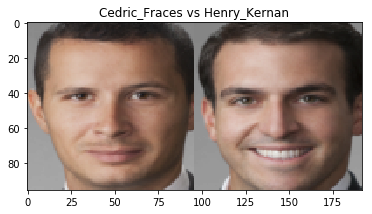

Karen_Chen Tailai_Wen 0.33667645973642024


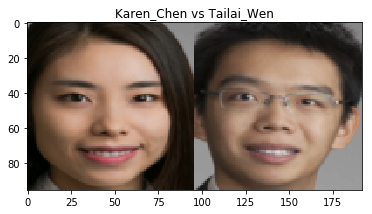

Sunnie_Wu Veronica_Salazar 0.33754165251816587


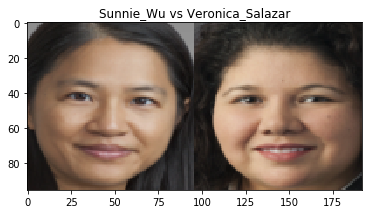

Sheree_Brunes Yuhan_Zhang 0.33817716844414225


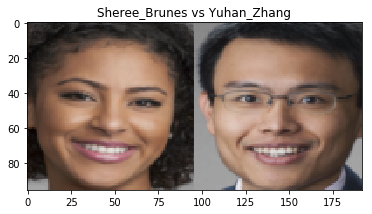

Jeremy_Xia Yuhan_Zhang 0.34536822248309224


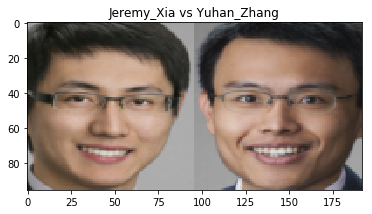

Jaime_Avendano John_Watkins 0.34935848849581375


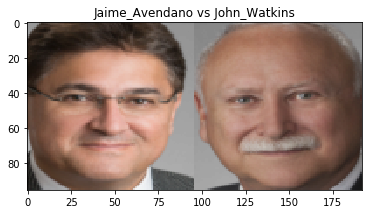

Sunnie_Wu Xiang_Zhai 0.35147139907916336


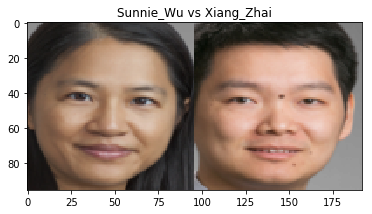

Shavran_Reddy Wassim_Benhallam 0.353345071403684


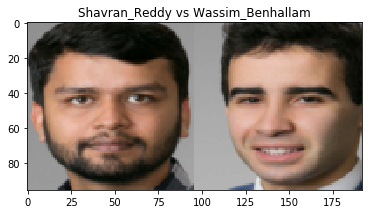

Amir_Kianinejad Jacqueline_Bosworth 0.3544664028685089


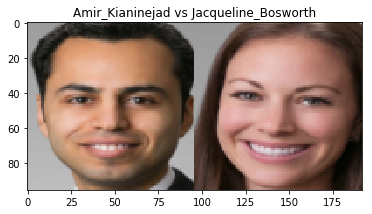

Mohammad_Shahvali Shah_Kabir 0.35574549059313104


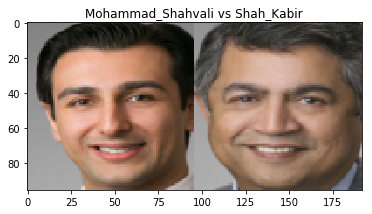

Amir_Kianinejad Wassim_Benhallam 0.3603631857304927


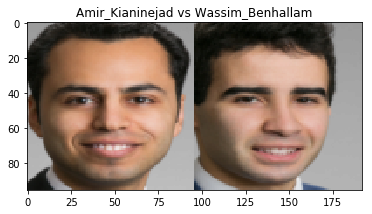

Amir_Kianinejad Wassim_Benhallam 0.36213962645357


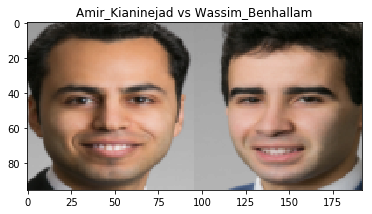

Jenna_Salamah Sheree_Brunes 0.3625217139920216


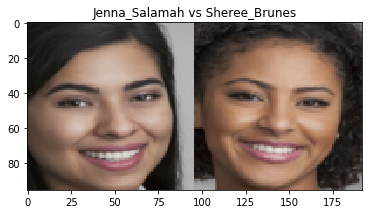

Fayadhoi_Ibrahima Shah_Kabir 0.3647104822401882


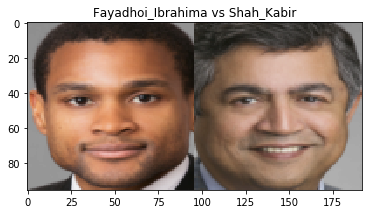

Jeff_Hutchison Umut_Ozdogan 0.36639749901198904


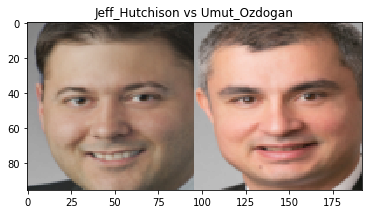

Meher_Surendra Yuhan_Zhang 0.36701559636151115


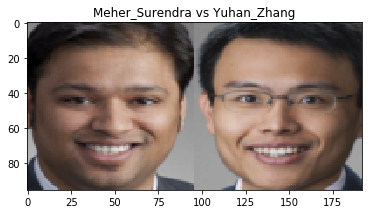

Humberto_Godinez Mohammad_Shahvali 0.3689955978187568


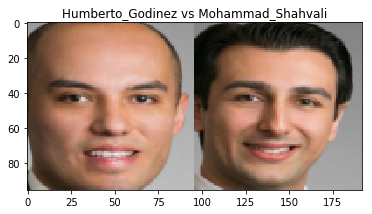

Karen_Chen Veronica_Salazar 0.37029825420301815


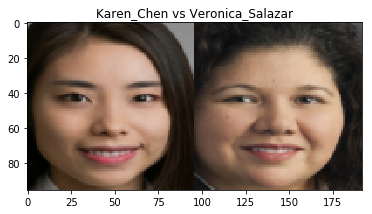

Amir_Kianinejad Rami_Kansao 0.37202953261039196


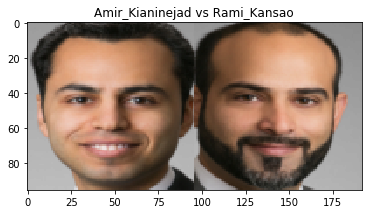

Ehsan_Davani Rees_Arnim 0.3730462685321571


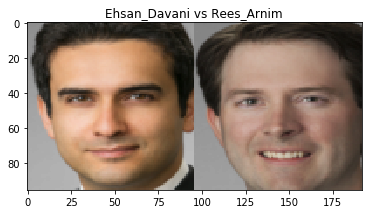

Meher_Surendra Tailai_Wen 0.3733380061293287


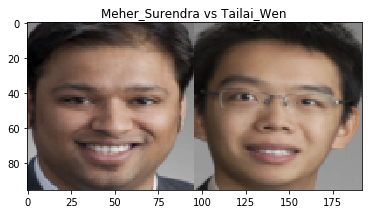

Amir_Kianinejad Wassim_Benhallam 0.3733777445017018


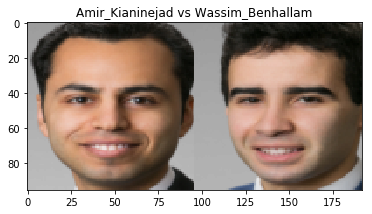

Lewis_Pham Tailai_Wen 0.3756101997499211


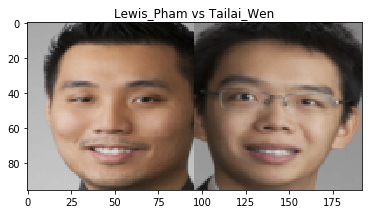

Ali_Garkasi Rami_Kansao 0.37626609120646587


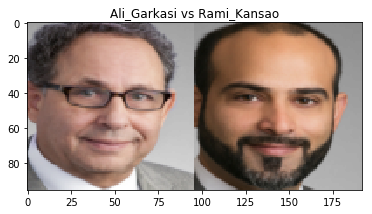

Anastasiya_Protasov Sunnie_Wu 0.3775938291836762


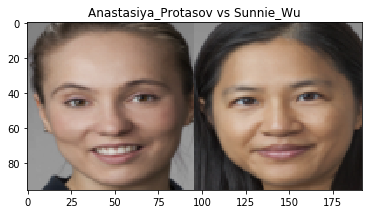

Henry_Kernan Kara_Bennett 0.3779002978410558


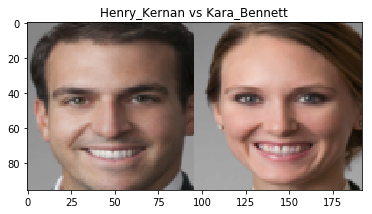

Aldo_Sanchez Wassim_Benhallam 0.37801101929482467


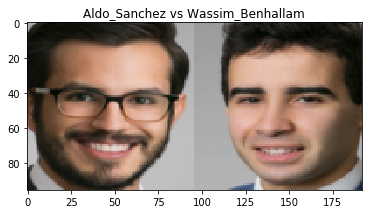

Amir_Kianinejad Rami_Kansao 0.3783006065132915


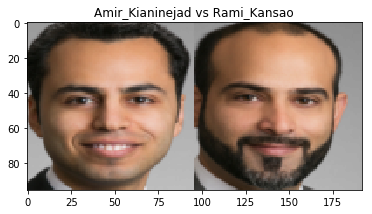

Izzet_Arslan Jeff_Hutchison 0.3785376573522524


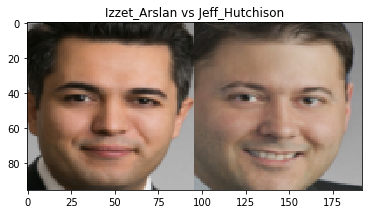

Meher_Surendra Yuhan_Zhang 0.3790356644243089


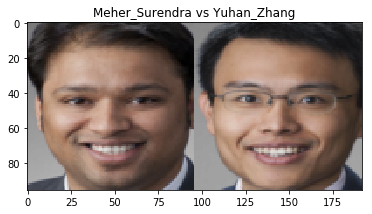

Jenna_Salamah Meher_Surendra 0.37967368865930107


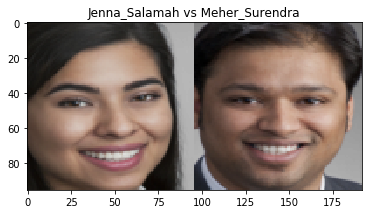

Sunnie_Wu Yuhan_Zhang 0.38037065752893723


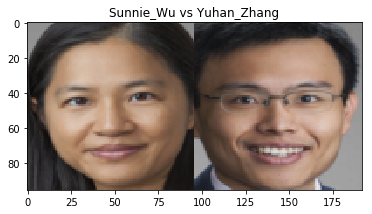

Jenna_Salamah Tailai_Wen 0.3807833767994244


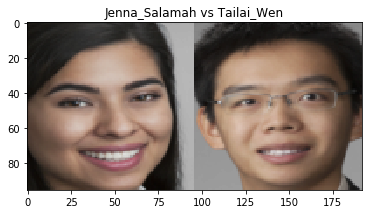

Humberto_Godinez Mohammad_Shahvali 0.380889340622546


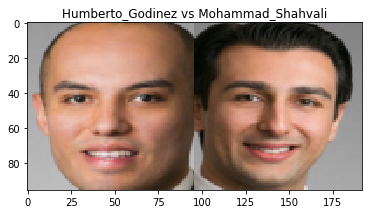

Meher_Surendra Tailai_Wen 0.38333610487442343


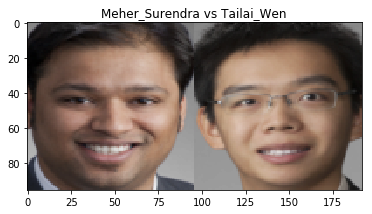

Cedric_Fraces Ehsan_Davani 0.38343023519529296


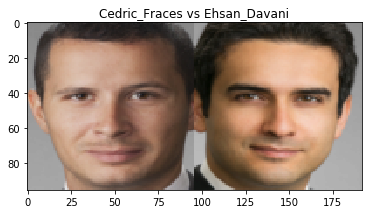

Anastasiya_Protasov Sunnie_Wu 0.38343058974936717


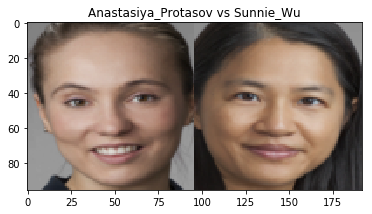

Jeremy_Xia Lewis_Pham 0.3847535358442997


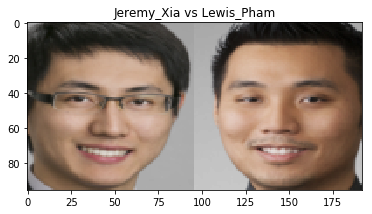

In [28]:
idx = np.argsort(Distances_cross_dist)[:50]
for i in idx:
    (p1,p2) = Distances_cross_dist_pair[i]
    print(name_list[labels[p1]], name_list[labels[p2]], Distances_cross_dist[i])
    tmp = np.concatenate((FaceData[p1],FaceData[p2]),axis=2)
    plt.figure()
    plt.imshow(np.transpose(tmp, (1,2,0)))
    plt.title(name_list[labels[p1]]+' vs '+name_list[labels[p2]])
    plt.show()

## Now try to do recognition!

In [31]:
def distance_based_prediction(FaceIm, FaceEmbedding, name_list, labels, th=0.2):
    FaceIm = misc.imresize(FaceIm,(96,96,3))
    FaceIm = np.around(np.transpose(FaceIm, (2,0,1))/255.0, decimals=12)
    FaceVector = FNModel.predict(np.array([FaceIm]))
    D = face_dist(FaceEmbedding,FaceVector)
    i = np.argmin(D)
    if D[i]>th:
        return name_list[labels[i]], D[i]
    else:
        return "Not recognizable", D[i]

In [32]:
def get_fullhead(x,y,w,h):
    new_h = int(h*1.3)
    new_w = int(w*1.0)
    y = int(y - h*0.2)
    x = int(x - w*0.0)
    return x,y,new_w,new_h

In [33]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

C:\Users\xiang.zhai\AppData\Local\Continuum\miniconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


23


C:\Users\xiang.zhai\AppData\Local\Continuum\miniconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


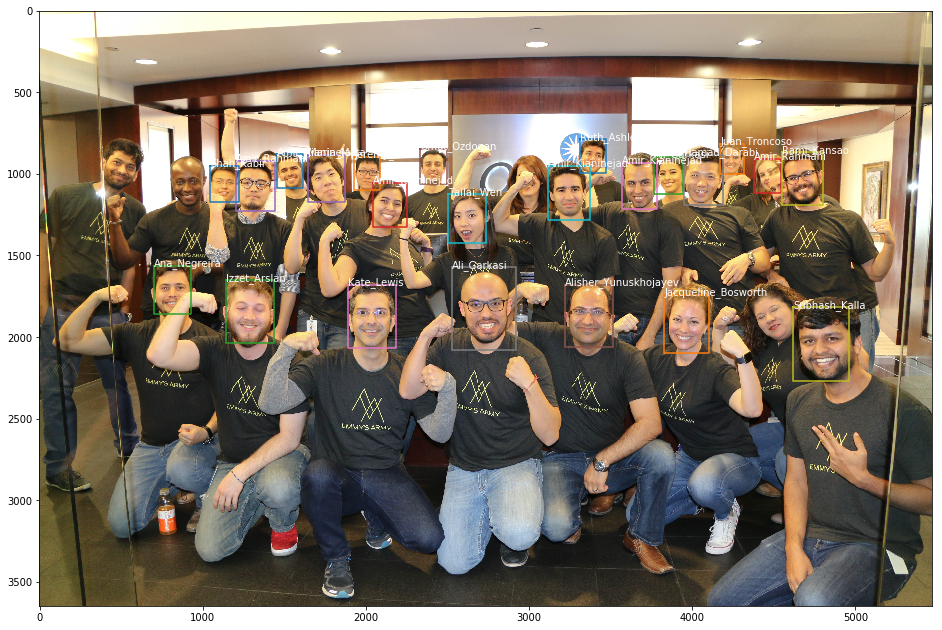

In [35]:
imName = 'Emmy Army.jpg'
im = misc.imread(imName)

imgray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(im, 1.3, 5)
print(len(faces))

plt.figure(figsize=(16,12))
plt.imshow(im)
for (x,y,w,h) in faces:
    (x,y,w,h) = get_fullhead(x,y,w,h)
    p, d =  distance_based_prediction(im[y:y+h,x:x+w], FaceEmbedding, name_list, labels)
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    plt.text(x,y,p,color='white')
    


C:\Users\xiang.zhai\AppData\Local\Continuum\miniconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


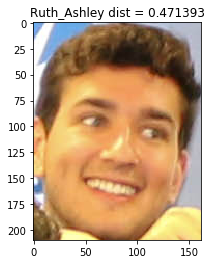

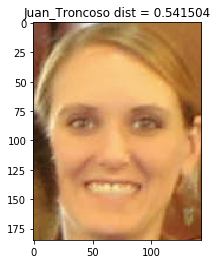

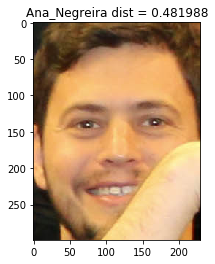

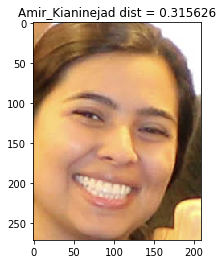

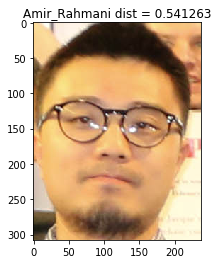

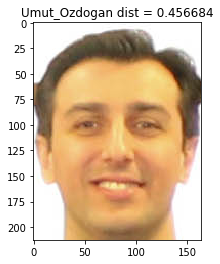

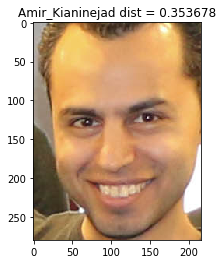

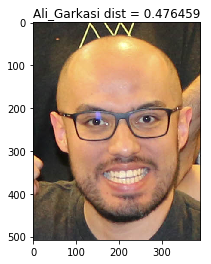

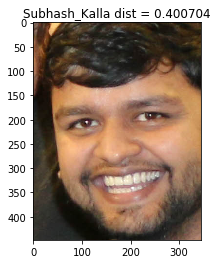

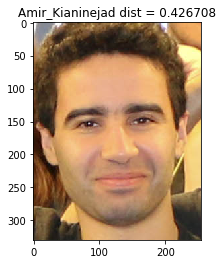

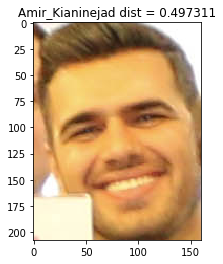

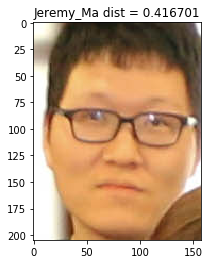

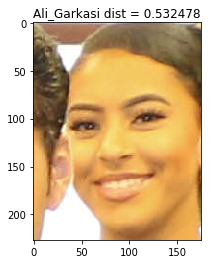

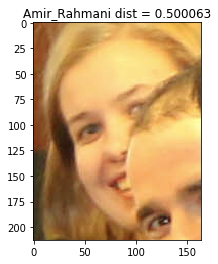

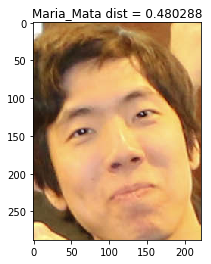

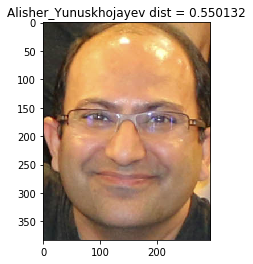

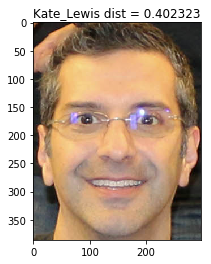

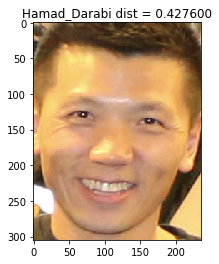

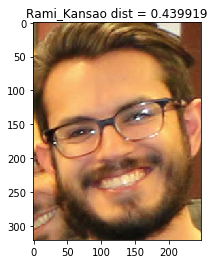

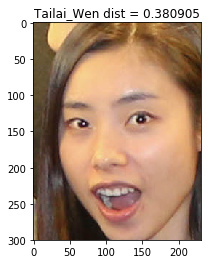

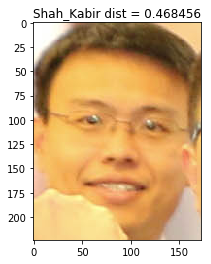

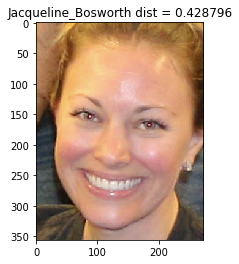

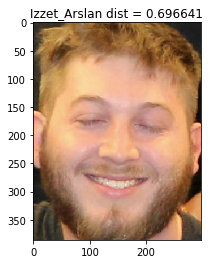

In [36]:
for (x,y,w,h) in faces:
    (x,y,w,h) = get_fullhead(x,y,w,h)
    p, d =  distance_based_prediction(im[y:y+h,x:x+w], FaceEmbedding, name_list, labels)
    #print(p)
    #plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    #plt.text(x,y,p,color='white')
    plt.figure()
    plt.imshow(im[y:y+h,x:x+w])
    plt.title(p + ' dist = %f' % d)
    plt.show()

### Note:
Apparently, the model does not do a good recognition job. Now we need to tune the model for QRI face dataset

## Generate positive and negative combinations to train binary Siamese model built on top of the FaceNet model

In [23]:
def VecDist(tensors):
    dist = K.sum(K.square(tensors[0]-tensors[1]),axis=-1)
    return dist

In [24]:
def Create_Siamese_binary_model(basemodel):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    
    p1_Input  = Input(basemodel_input_shape)
    p2_Input  = Input(basemodel_input_shape)
    
    p1_Prediction = basemodel(p1_Input)
    p2_Prediction = basemodel(p2_Input)
    
    dist = Lambda(VecDist, output_shape=(1,))([p1_Prediction,p2_Prediction])
    
    SiameseModel = Model(inputs = [p1_Input, p2_Input], outputs = dist)
    
    return SiameseModel 

In [25]:
def binary_loss(y_true, y_pred, threshold = 1.0):

    loss = K.sum(K.maximum(threshold- y_pred, 0.0))
    #loss = K.sum(-y_pred)

    return loss

In [26]:
SiameseModel = Create_Siamese_binary_model(FNModel)

In [27]:
SiameseModel.output

<tf.Tensor 'lambda_1/Sum:0' shape=(?,) dtype=float32>

In [28]:
opt = optimizers.adam(lr=0.002, beta_1=0.9, beta_2=0.999)
SiameseModel.compile(optimizer = opt, loss = binary_loss)

2000 number of P, N combinations had been identified


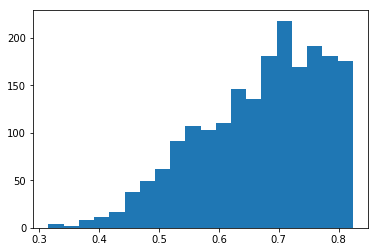

Epoch 1/1
2000/2000 [==============================] - 445s 223ms/step - loss: 0.8664
Wall time: 4.83 s


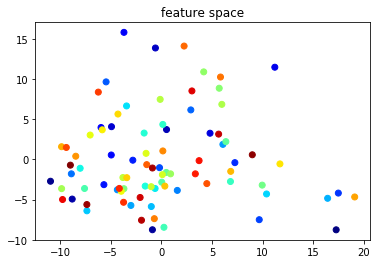

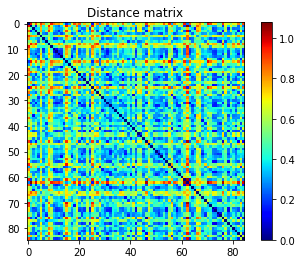

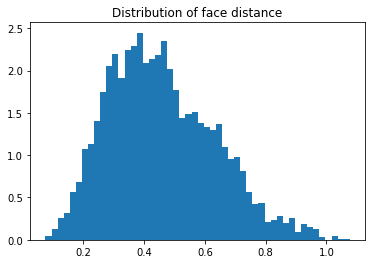

Cross-class distance = 0.457 +\- 0.174
2000 number of P, N combinations had been identified


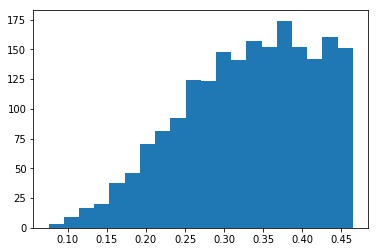

Epoch 1/1
2000/2000 [==============================] - 420s 210ms/step - loss: 1.0254
Wall time: 4.84 s


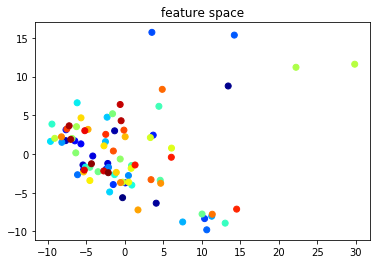

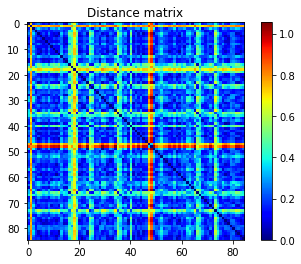

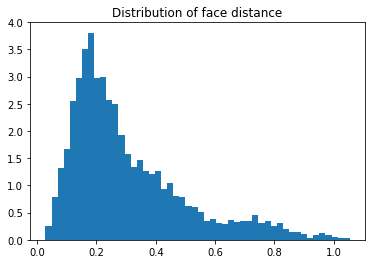

Cross-class distance = 0.305 +\- 0.195
2000 number of P, N combinations had been identified


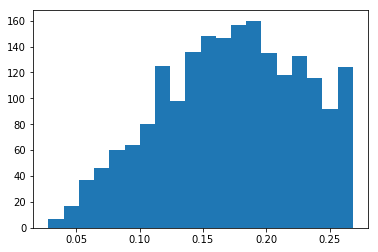

Epoch 1/1
2000/2000 [==============================] - 423s 212ms/step - loss: 1.0392
Wall time: 4.86 s


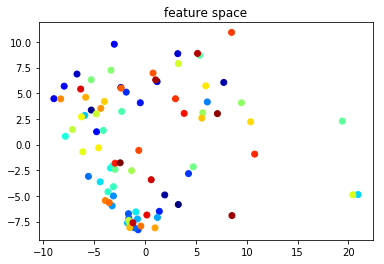

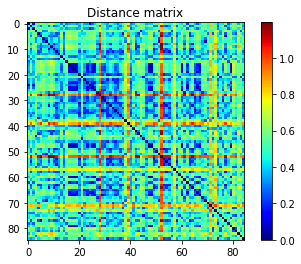

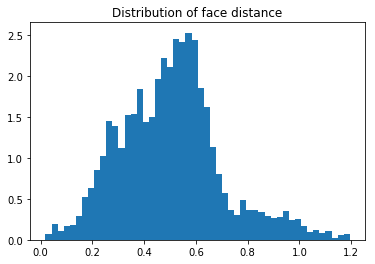

Cross-class distance = 0.503 +\- 0.197
2000 number of P, N combinations had been identified


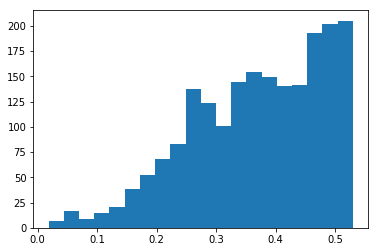

Epoch 1/1
 304/2000 [===>..........................] - ETA: 6:02 - loss: 1.0957

KeyboardInterrupt: 

In [29]:
for i in range(10):
    # find hard to train positive and negative combination
    idx = np.argsort(Distances_cross_dist)
    nPN = 2000
    P = [Distances_cross_dist_pair[i][0] for i in idx[:nPN]]
    N = [Distances_cross_dist_pair[i][1] for i in idx[:nPN]]

    print('%d number of P, N combinations had been identified' % nPN)
    plt.figure()
    plt.hist(Distances_cross_dist[idx[:nPN]],bins=20)
    plt.show()
    #SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
    SiameseModel.fit([FaceData[P],FaceData[N]], np.zeros((nPN,)), epochs = 1, batch_size = 16)
    
    %time FaceEmbedding = FNModel.predict(FaceData)
    
    pca = decomposition.PCA(n_components = 2)
    x_std = StandardScaler().fit_transform(FaceEmbedding)
    x_feature_pca = pca.fit_transform(x_std)
    plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels,cmap='jet')
    plt.title('feature space')
    plt.show()

    Distances_cross_dist = []
    Distances_cross_dist_pair = []
    FaceEmbedding_Dist = np.ones((nFace,nFace))*100
    for i in range(nFace):
        for j in range(i,nFace):
            FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
            FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
            if labels[i]!=labels[j]:
                Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
                Distances_cross_dist_pair.append((i,j))

    Distances_cross_dist = np.array(Distances_cross_dist)

    plt.figure()
    plt.imshow(FaceEmbedding_Dist,cmap='jet')
    plt.title('Distance matrix')
    plt.colorbar()
    plt.show()

    plt.figure()
    _ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
    plt.title('Distribution of face distance')
    plt.show()

    print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))
    

In [ ]:
%time FaceEmbedding = FNModel.predict(FaceData)

In [ ]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels,cmap='jet')
plt.title('feature space')

Distances_cross_dist = []
Distances_cross_dist_pair = []
FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]!=labels[j]:
            Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
            Distances_cross_dist_pair.append((i,j))
            
Distances_cross_dist = np.array(Distances_cross_dist)

plt.figure()
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

plt.figure()
_ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
plt.title('Distribution of face distance')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))